In [53]:
## Manipulación de datos
import pandas as pd
import numpy as np
import polars as pl
## Visualización
import matplotlib.pyplot as plt
import seaborn as sns

## Modelos
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import root_mean_squared_error,mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [54]:
df = pl.read_parquet(r'..\data\processed\realtor-ml.parquet')
population = pl.read_csv(r'..\data\raw\US Population by Zip Code.csv')

In [55]:
new_columns = population.row(0)

population = (
    population.slice(1)
    .rename({old: new for old, new in zip(population.columns, new_columns)})
)

In [56]:
population = population.with_columns(
    pl.col("Geographic Area Name").str.splitn(" ", 2).alias("split_geo")
).with_columns([
    pl.col("split_geo").struct.field("field_0").alias("zcta_code"),
    pl.col("split_geo").struct.field("field_1").alias("zip_code")
]).drop("split_geo")

population = population.drop(["Geographic Area Name", "Geography", "zcta_code"])

population = population.rename({" Total Population": "total_population"})

print(population.head())

shape: (5, 2)
┌──────────────────┬──────────┐
│ total_population ┆ zip_code │
│ ---              ┆ ---      │
│ str              ┆ str      │
╞══════════════════╪══════════╡
│ 17242            ┆ 00601    │
│ 37548            ┆ 00602    │
│ 49804            ┆ 00603    │
│ 5009             ┆ 00606    │
│ 25731            ┆ 00610    │
└──────────────────┴──────────┘


In [57]:
population = population.with_columns([
    pl.col("zip_code").cast(pl.Float64),
    pl.col("total_population").cast(pl.Float64)
])

In [58]:
df = df.join(population, on='zip_code', how='left')

In [59]:
df = df.to_pandas()

In [60]:
df.head()

,price,bed,bath,acre_lot,street,city,state,zip_code,house_size,size_bin,...,price_per_sqft,total_rooms,bed_group_10o+,bath_group_10o+,status_sold,region_group_Northeast,region_group_Other,region_group_South,region_group_West,total_population
0,105000.0,3.0,2.0,0.12,1962661.0,62,40,601.0,920.0,2,...,114.130435,5.0,0,0,0,0,1,0,0,17242.0
1,80000.0,4.0,2.0,0.08,1902874.0,62,40,601.0,1527.0,4,...,52.390308,6.0,0,0,0,0,1,0,0,17242.0
2,67000.0,2.0,1.0,0.15,1404990.0,7553,40,795.0,748.0,2,...,89.572193,3.0,0,0,0,0,1,0,0,43745.0
3,145000.0,4.0,2.0,0.10,1947675.0,12277,40,731.0,1800.0,4,...,80.555556,6.0,0,0,0,0,1,0,0,12292.0
4,179000.0,4.0,3.0,0.46,1850806.0,13607,40,612.0,2520.0,5,...,71.031746,7.0,0,0,0,0,1,0,0,62425.0


In [61]:
df.shape

(1376838, 26)

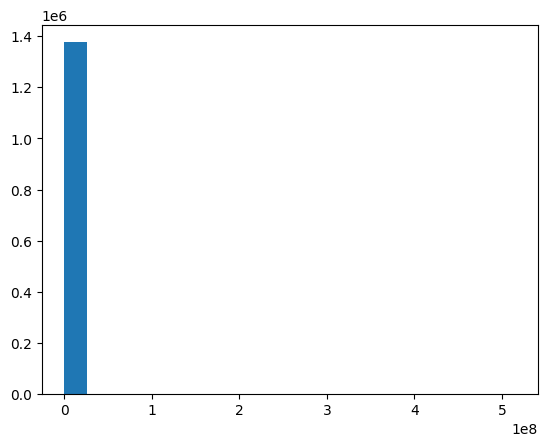

In [62]:
plt.hist(df['price'],bins=20);

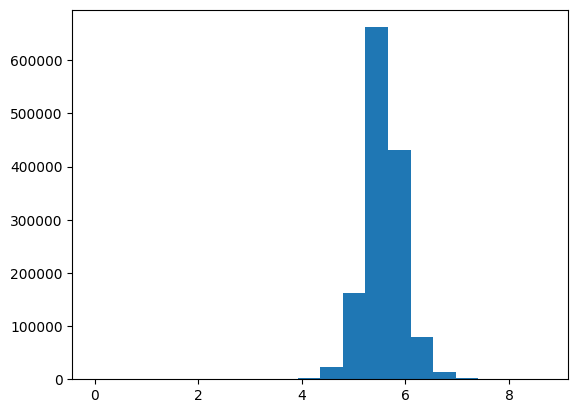

In [63]:
plt.hist(np.log10(df['price']),bins=20);

In [64]:
# df = df[(df['price'] >= 10000) & (df['price'] <= 10_000_000)]

In [65]:
df['price_range'] = pd.cut(df['price'], bins=[0, 500_000, 1_000_000, np.inf], labels=[0,1,2])

In [66]:
df.dropna(inplace=True)

In [67]:
df['bed_log'] = np.log1p(df['bed'])
df['bath_log'] = np.log1p(df['bath'])
df['house_size_log'] = np.log1p(df['house_size'])
df['acre_lot_log'] = np.log1p(df['acre_lot'])
df['price_sqrt'] = np.sqrt(df['price'])

In [68]:
df['bed_bath_balance']=df['bed_log']*df['bath_log']
df['price_per_sqft']=df['price_sqrt']/df['house_size_log']
df['price_per_bedroom']=df['price_sqrt']/df['bed_log']
df['average_size_room'] = df['house_size_log'] / (df['bed_log'].replace(0, np.nan))
df['bed_bath_ratio'] = df['bed_log'] / (df['bath_log'].replace(0, np.nan))
df['efficient_land_use'] = df['house_size_log'] / (df['acre_lot_log'].replace(0, np.nan))
df['bed_bath_balance_log'] = np.log1p(df['bed_bath_balance'])
df['avg_price_by_city'] = np.log1p(df.groupby('city')['price'].transform('median'))
df['avg_price_by_state'] = np.log1p(df.groupby('state')['price'].transform('median'))
df['people_per_home'] = df['total_population'] / df.groupby('zip_code')['house_size'].transform('count')
df['pop_density'] = df['total_population'] / df['acre_lot']
df['avg_house_size_by_city'] = df.groupby('city')['house_size'].transform('median')
df['street'] = np.log1p(df['street'])

In [69]:
zip_counts = df['zip_code'].value_counts()
valid_zips = zip_counts[zip_counts >= 10].index

avg_price_zip = (
    df[df['zip_code'].isin(valid_zips)]
    .groupby('zip_code')['price']
    .mean()
    .to_dict()
)

df['avg_price_by_zip'] = df['zip_code'].map(avg_price_zip)

avg_price_state = df.groupby('state')['price'].mean().to_dict()
df['avg_price_by_state'] = df['state'].map(avg_price_state)

df['avg_price_by_zip'] = df['avg_price_by_zip'].fillna(df['avg_price_by_state'])

In [70]:
df.dropna(inplace=True)

In [71]:
num_features=['bed_bath_balance', 'average_size_room', 'bed_bath_ratio',
            'efficient_land_use', 'price_per_sqft', 'price_per_bedroom']

for column in num_features:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df= df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

In [72]:
X = df.drop(columns=['price', 'price_category', 'is_luxury_home', 'price_per_sqft',
                     'property_type','bath_group','bed_group','price_range'
                     ,'bed', 'bed_log','bed_group_10o+',
       'bath_group_10o+'
])

y = np.log1p(df['price'])

In [73]:
X = X[['bath', 'acre_lot', 'city', 'state', 'zip_code', 'house_size',
       'bed_bath_ratio', 'total_rooms',
       'total_population', 'bath_log', 'house_size_log', 'acre_lot_log',
       'bed_bath_balance', 'average_size_room', 'efficient_land_use',
       'bed_bath_balance_log', 'avg_price_by_city', 'avg_price_by_state',
       'people_per_home', 'pop_density', 'avg_house_size_by_city',
       'avg_price_by_zip','street']]

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [75]:
xgb = XGBRegressor(
    n_estimators=300,
    max_depth=15,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    n_jobs=-1,
    random_state=42
)

In [76]:
xgb.fit(X_train, y_train)

xgb_pred = xgb.predict(X_test)

xgb_pred = np.expm1(xgb_pred)
y_true = np.expm1(y_test)

rmse = root_mean_squared_error(y_true, xgb_pred)
mape = mean_absolute_percentage_error(y_true, xgb_pred)

print('RMSE xgb data set General:', round(rmse, 2))
print('MAPE xgb data set General:', round(mape * 100, 2), '%')

RMSE xgb data set General: 97636.18
MAPE xgb data set General: 18.04 %


In [26]:
price_range_test = df.loc[X_test.index, 'price_range']
for segment in [0, 1, 2]:
    mask = price_range_test == segment
    mape = mean_absolute_percentage_error(y_true[mask], xgb_pred[mask]) * 100
    rmse = root_mean_squared_error(y_true[mask], xgb_pred[mask])
    print(f"Segmento {segment} → MAPE randonforest: {mape:.2f}")
    print(f"Segmento {segment} → RMSE randonforest: {rmse:.2f}")

Segmento 0 → MAPE randonforest: 20.07
Segmento 0 → RMSE randonforest: 66575.23
Segmento 1 → MAPE randonforest: 12.88
Segmento 1 → RMSE randonforest: 125132.08
Segmento 2 → MAPE randonforest: 17.33
Segmento 2 → RMSE randonforest: 277837.86


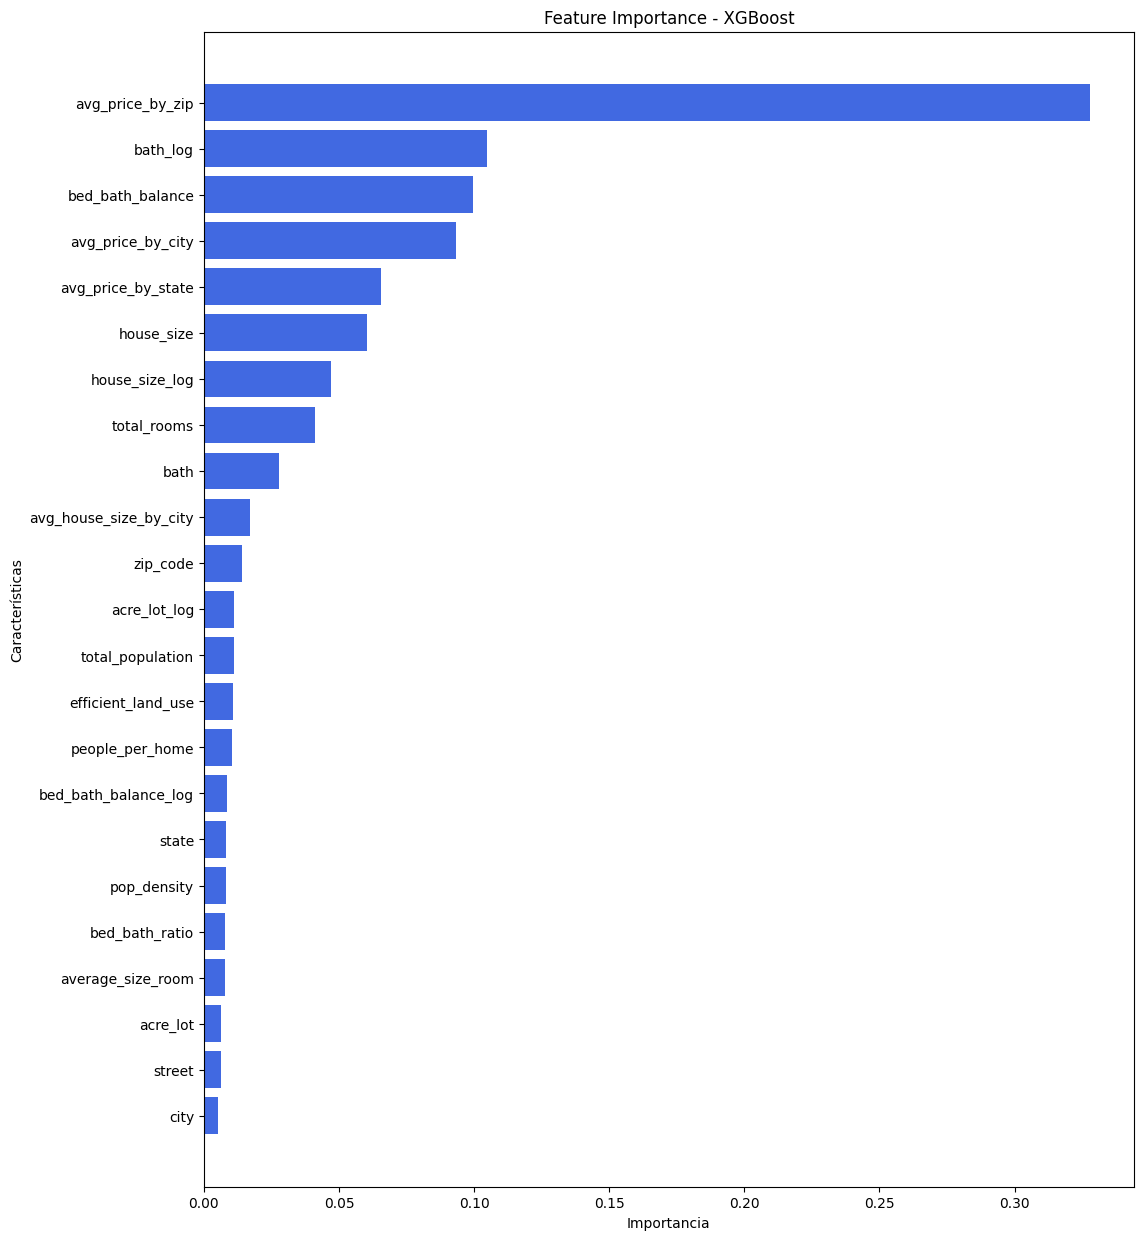

In [28]:
feature_importances = xgb.feature_importances_


selected_feature_names = X_train.columns


feature_importance_df = pd.DataFrame({
    "Feature": selected_feature_names,
    "Importance": feature_importances
})
feature_importance_df.sort_values(by='Importance',inplace=True)

plt.figure(figsize=(12, 15))
plt.barh(feature_importance_df["Feature"], feature_importance_df["Importance"], color="royalblue")
plt.xlabel("Importancia")
plt.ylabel("Características")
plt.title("Feature Importance - XGBoost")
plt.show()

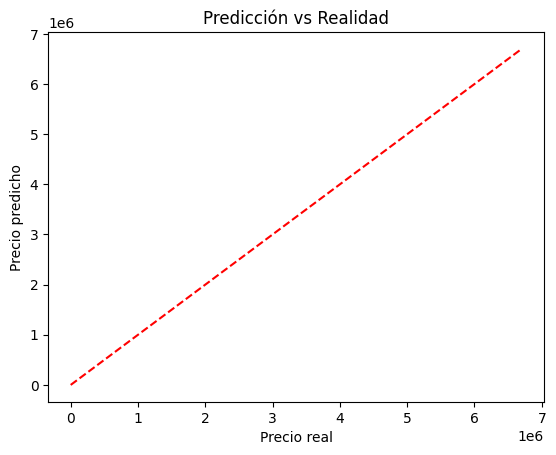

In [28]:
plt.scatter(np.expm1(y_test), np.expm1(xgb_pred), alpha=0.2)
plt.xlabel("Precio real")
plt.ylabel("Precio predicho")
plt.title("Predicción vs Realidad")
plt.plot([0, np.expm1(y_test).max()], [0, np.expm1(y_test).max()], 'r--')
plt.show()
